✓ All libraries imported successfully!
DATASET 1: IRIS
Shape: (150, 6)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

First 5 rows:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   species species_name  
0        0       setosa  
1        0       setosa  
2        0       setosa  
3        0       setosa  
4        0       setosa  

DATASET 2: MALL CUSTOMERS
Shape: (200, 5)
Features: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

First 5 rows:
   CustomerID  Gender  Age  Annual Income 

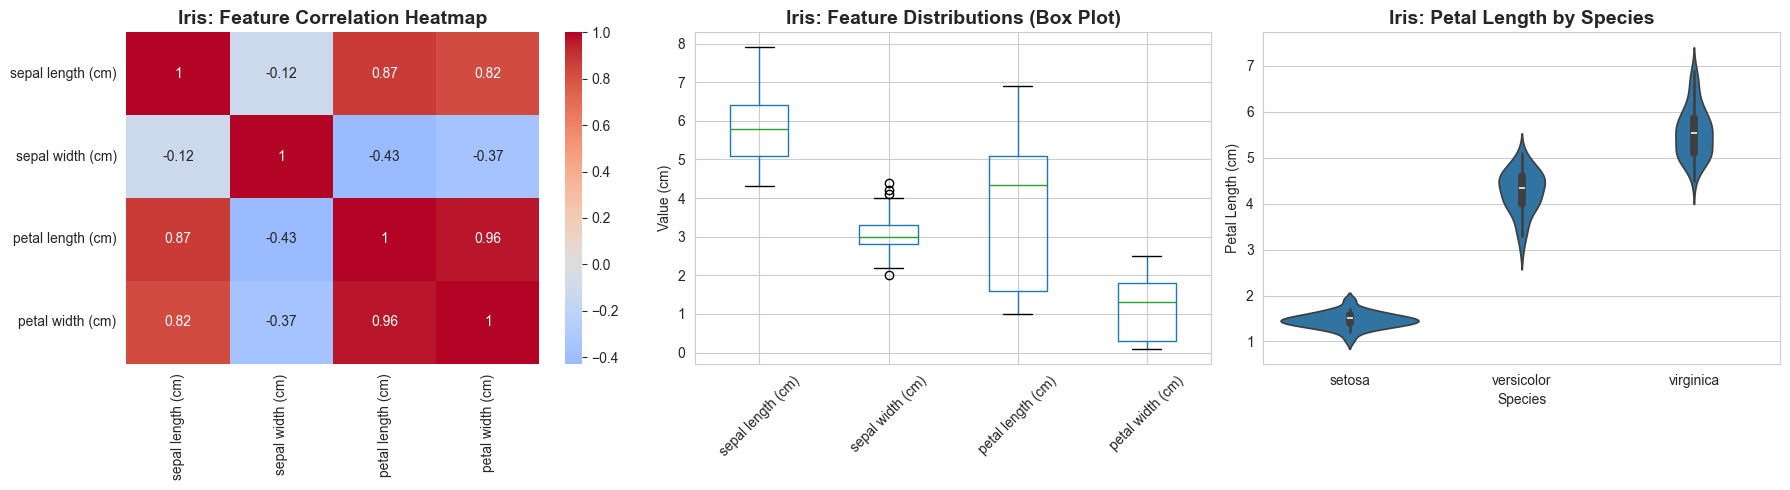


Outliers (Z-score > 3):
  sepal length (cm): 0
  sepal width (cm): 1
  petal length (cm): 0
  petal width (cm): 0

📊 KEY FINDINGS - IRIS:
  • Strong correlation between petal length and petal width (0.96)
  • Strong correlation between sepal length and petal length (0.87)
  • Species show distinct petal measurements
  • Minimal outliers detected

EDA: MALL CUSTOMERS DATASET

Descriptive Statistics:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   44.405000           39.158121               51.135000
std     57.879185   15.353816           13.217086               27.326736
min      1.000000   18.000000           15.663674                1.000000
25%     50.750000   32.750000           28.224801               29.750000
50%    100.500000   46.000000           36.736359               55.500000
75%    150.250000   56.000000           49.187193               73.000000
max  

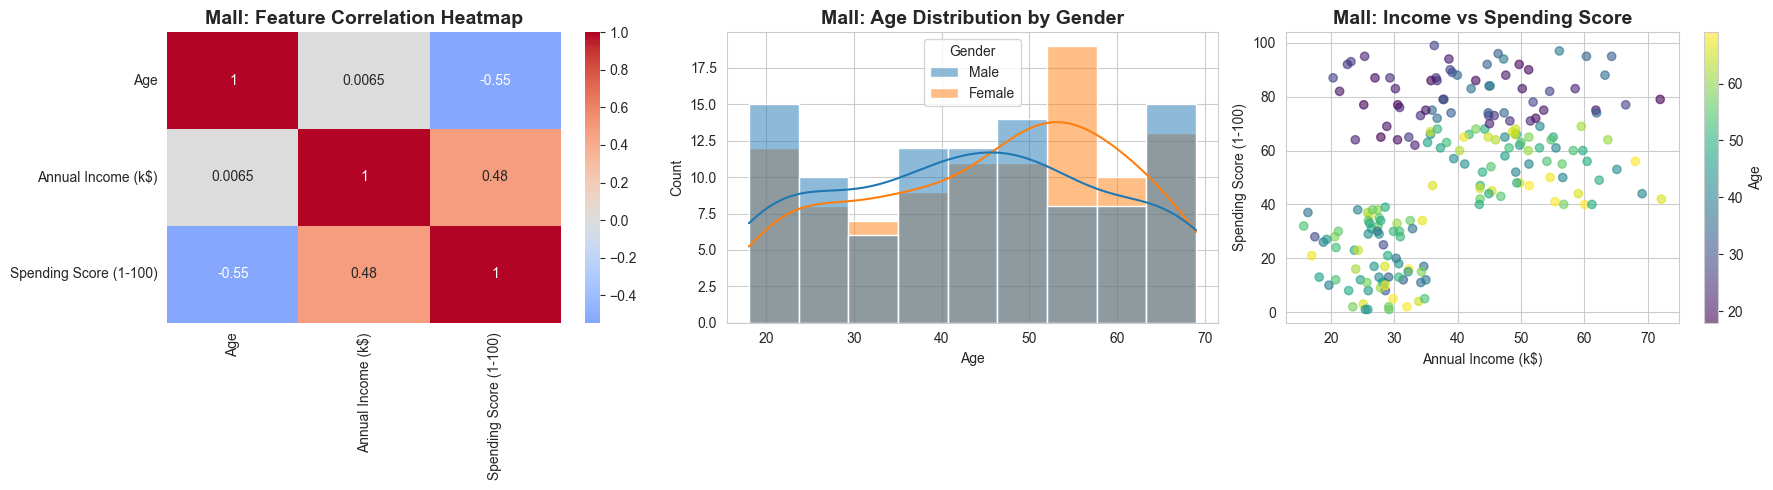


Outliers (Z-score > 3):
  Age: 0
  Annual Income (k$): 0
  Spending Score (1-100): 0

📊 KEY FINDINGS - MALL CUSTOMERS:
  • Age ranges from 18 to 70 years
  • No strong linear correlations between features
  • Multiple customer segments visible in income-spending plot
  • Balanced gender distribution

DATA PREPROCESSING
✓ Iris data standardized
  Shape: (150, 4)
✓ Mall data standardized
  Shape: (200, 3)

K-MEANS: ELBOW METHOD


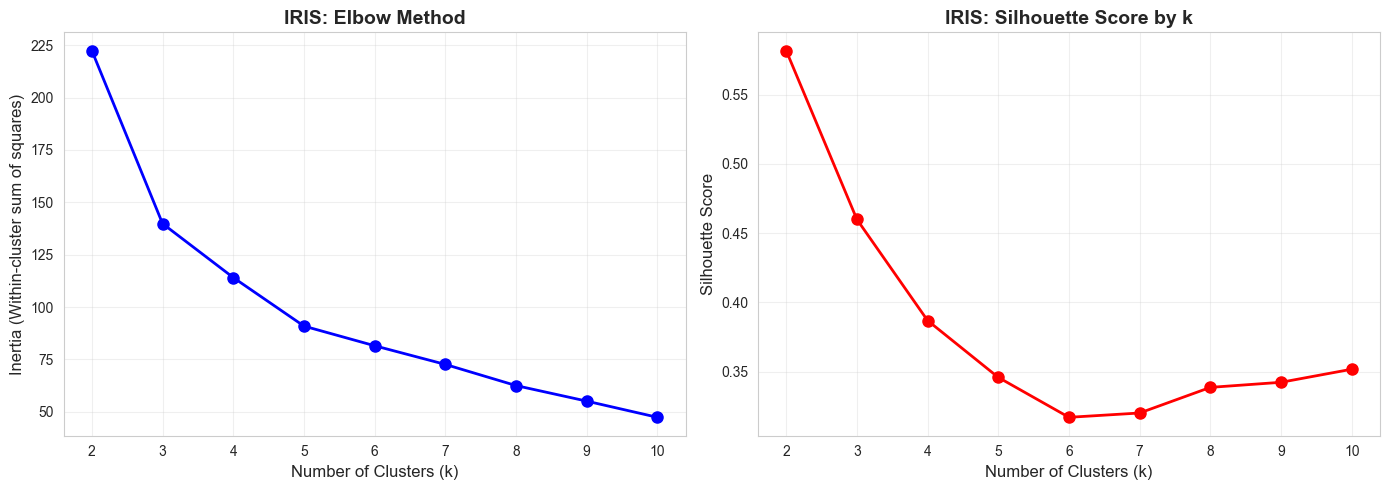


IRIS - Optimal k (Silhouette): 2
Max Silhouette Score: 0.5818


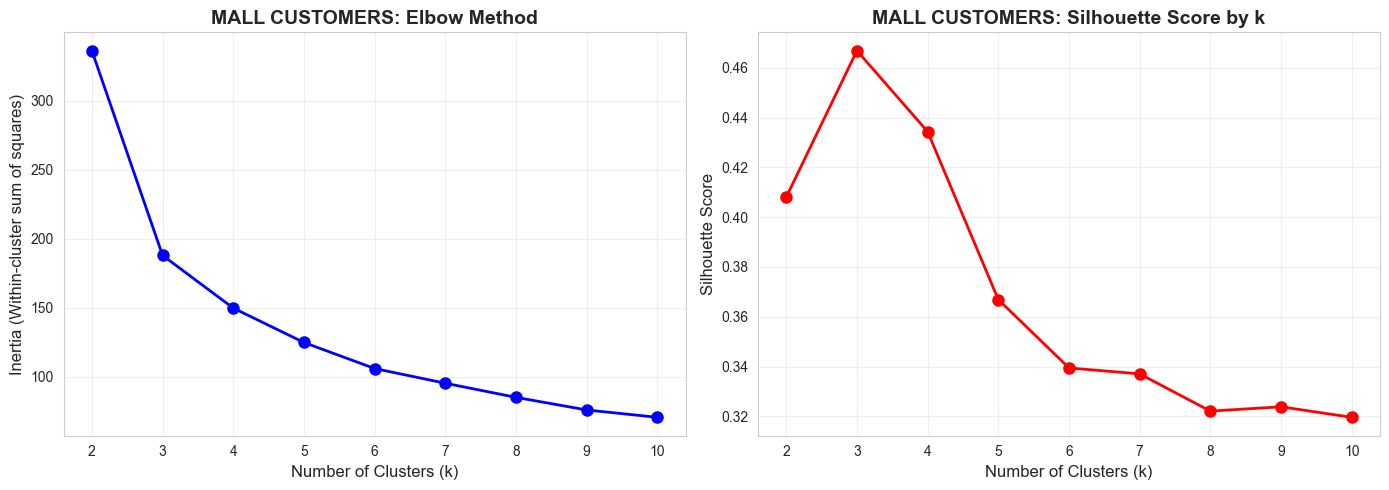


MALL CUSTOMERS - Optimal k (Silhouette): 3
Max Silhouette Score: 0.4669

K-MEANS: FINAL CLUSTERING

IRIS K-MEANS (k=3):
  Inertia: 139.8205
  Silhouette Score: 0.4599
  Davies-Bouldin Index: 0.8336
  Calinski-Harabasz Score: 241.9044

MALL CUSTOMERS K-MEANS (k=5):
  Inertia: 124.7108
  Silhouette Score: 0.3669
  Davies-Bouldin Index: 0.9792
  Calinski-Harabasz Score: 185.7927

HIERARCHICAL CLUSTERING: DENDROGRAMS


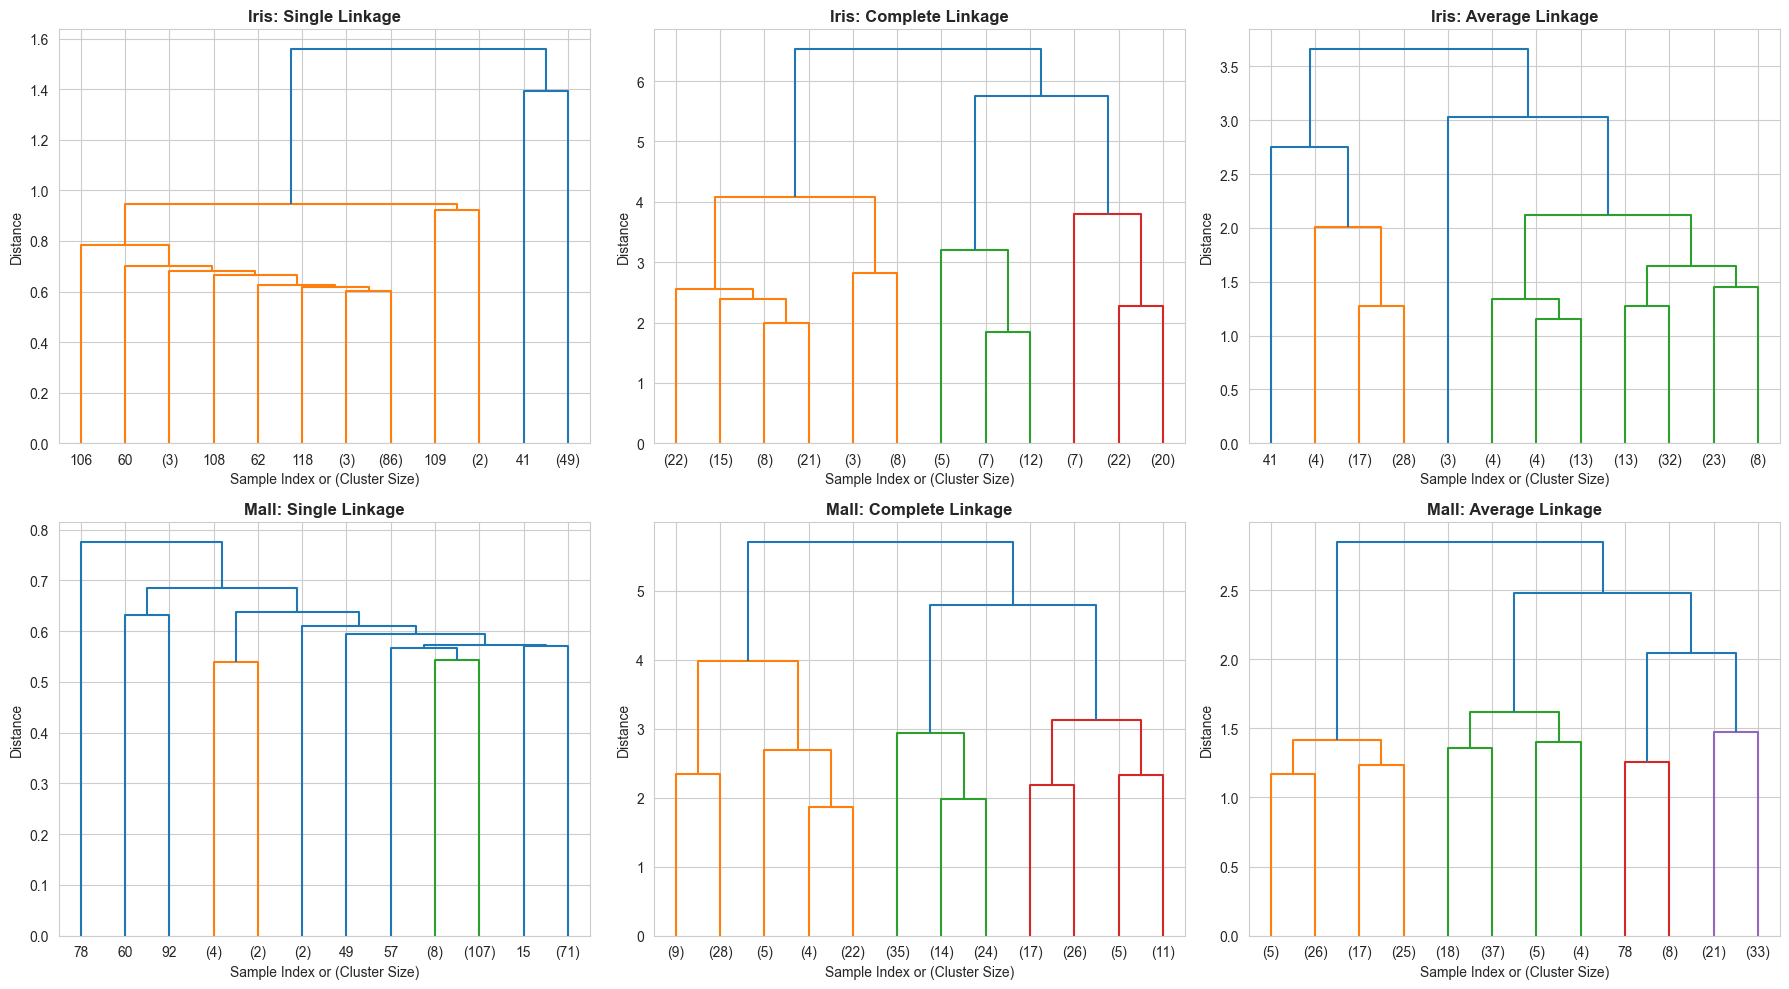

✓ Dendrograms generated for both datasets with 3 linkage methods

HIERARCHICAL CLUSTERING: FINAL MODELS

Linkage Method Comparison:
 Linkage  Iris Silhouette  Mall Silhouette
  single         0.504646         0.064428
complete         0.449618         0.367626
 average         0.480267         0.382206
    ward         0.446689         0.346050

✓ Final Models Created:
  Iris: average linkage, 3 clusters
  Mall: ward linkage, 5 clusters

CLUSTER VISUALIZATION: PCA


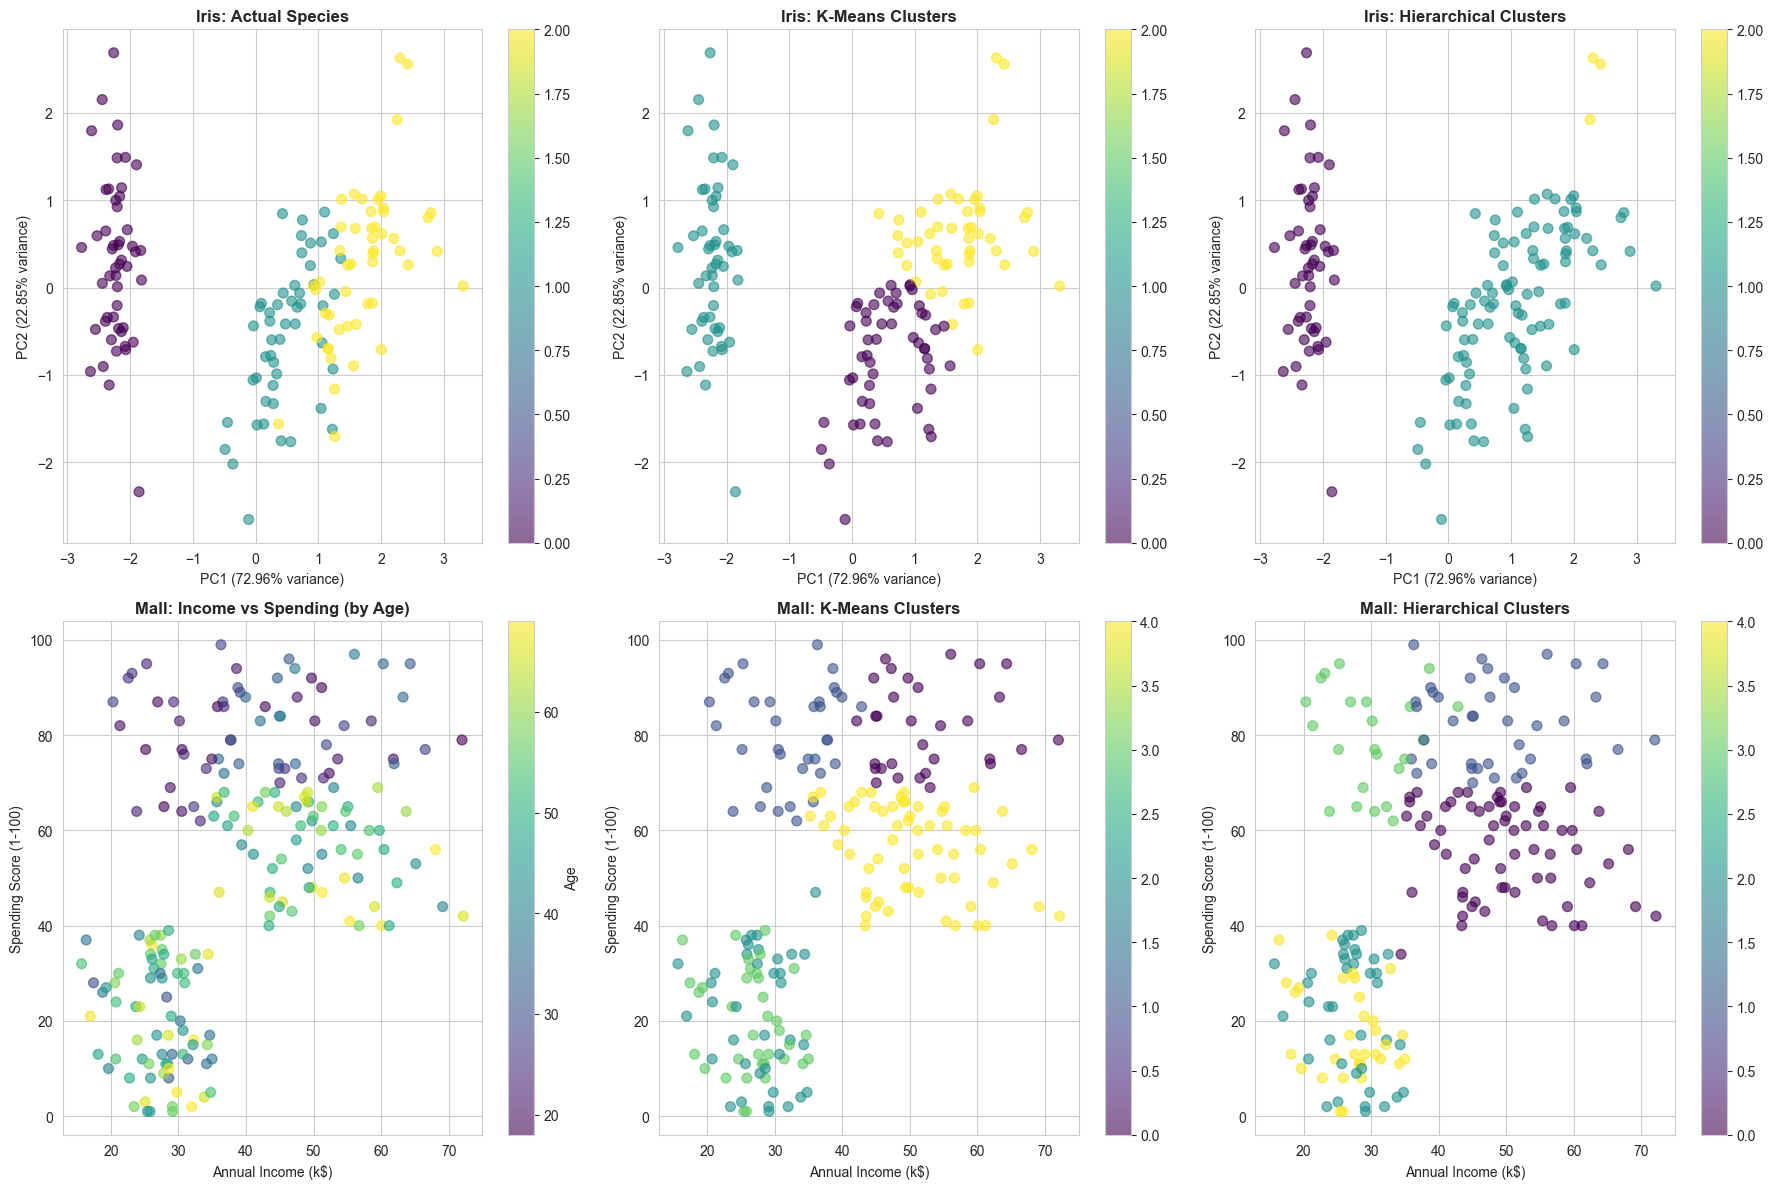

✓ Iris PCA - Explained Variance: 95.81%
✓ Mall PCA - Explained Variance: 91.01%

QUANTITATIVE COMPARISON OF CLUSTERING ALGORITHMS

Clustering Performance Metrics:
Dataset    Algorithm  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score
   Iris      K-Means          0.459948              0.833595               241.904402
   Iris Hierarchical          0.480267              0.575269               149.025799
   Mall      K-Means          0.366885              0.979193               185.792711
   Mall Hierarchical          0.346050              0.994489               171.372267

📊 Metric Interpretation:
  • Silhouette Score: Higher is better (range: -1 to 1)
  • Davies-Bouldin Index: Lower is better (minimum: 0)
  • Calinski-Harabasz Score: Higher is better

CLUSTER INTERPRETATION AND INSIGHTS

IRIS DATASET - K-MEANS CLUSTERS
                sepal length (cm)  sepal width (cm)  petal length (cm)  \
kmeans_cluster                                                           
0     

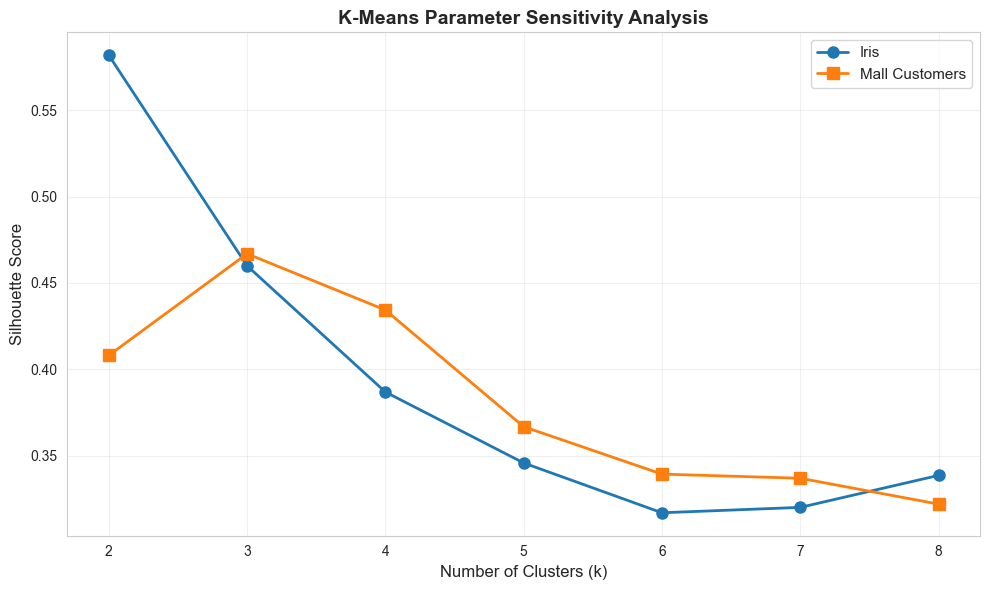


Sensitivity Analysis Results:
 k  Iris Silhouette  Mall Silhouette
 2         0.581750         0.408089
 3         0.459948         0.466903
 4         0.386941         0.434363
 5         0.345901         0.366885
 6         0.317079         0.339440
 7         0.320197         0.337049
 8         0.338692         0.322090


In [1]:
"""
Comprehensive Clustering Analysis: K-Means vs Hierarchical Clustering
Dataset Comparison: Iris and Mall Customers

Author: Data Science Team
Date: November 2025
"""

# ============================================================================
# PART 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")

# ============================================================================
# PART 2: DATASET LOADING
# ============================================================================

# Dataset 1: Iris
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target
iris_df['species_name'] = iris_df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

print("=" * 70)
print("DATASET 1: IRIS")
print("=" * 70)
print(f"Shape: {iris_df.shape}")
print(f"Features: {list(iris.feature_names)}")
print(f"\nFirst 5 rows:")
print(iris_df.head())

# Dataset 2: Mall Customers (Creating synthetic data based on typical mall customer dataset)
np.random.seed(42)
n_customers = 200

# Generate customer data
customer_ids = range(1, n_customers + 1)
genders = np.random.choice(['Male', 'Female'], n_customers)
ages = np.random.randint(18, 70, n_customers)

# Create distinct customer segments
segment1 = np.random.normal(25, 5, 50)  # Young, low income
segment2 = np.random.normal(55, 8, 50)  # Old, low income
segment3 = np.random.normal(30, 7, 50)  # Young, high income
segment4 = np.random.normal(45, 10, 50) # Middle-aged, high income

annual_income = np.concatenate([segment1, segment2, segment3, segment4])
spending_score = np.zeros(n_customers)

# Spending based on income and age patterns
for i in range(n_customers):
    if annual_income[i] < 35 and ages[i] < 30:
        spending_score[i] = np.random.randint(60, 100)  # Young, low income, high spending
    elif annual_income[i] < 35 and ages[i] >= 30:
        spending_score[i] = np.random.randint(1, 40)    # Old, low income, low spending
    elif annual_income[i] >= 35 and ages[i] < 40:
        spending_score[i] = np.random.randint(70, 100)  # Young, high income, high spending
    else:
        spending_score[i] = np.random.randint(40, 70)   # Middle-aged, moderate spending

mall_df = pd.DataFrame({
    'CustomerID': customer_ids,
    'Gender': genders,
    'Age': ages,
    'Annual Income (k$)': annual_income,
    'Spending Score (1-100)': spending_score
})

print("\n" + "=" * 70)
print("DATASET 2: MALL CUSTOMERS")
print("=" * 70)
print(f"Shape: {mall_df.shape}")
print(f"Features: {list(mall_df.columns)}")
print(f"\nFirst 5 rows:")
print(mall_df.head())

# ============================================================================
# PART 3: EXPLORATORY DATA ANALYSIS - IRIS DATASET
# ============================================================================

print("\n" + "=" * 70)
print("EDA: IRIS DATASET")
print("=" * 70)

# Basic statistics
print("\nDescriptive Statistics:")
print(iris_df.describe())

# Missing values
print(f"\nMissing Values:\n{iris_df.isnull().sum()}")

# Correlation matrix
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Correlation heatmap
iris_numeric = iris_df.drop(['species', 'species_name'], axis=1)
sns.heatmap(iris_numeric.corr(), annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Iris: Feature Correlation Heatmap', fontsize=14, fontweight='bold')

# Distribution plots
iris_df.drop(['species', 'species_name'], axis=1).boxplot(ax=axes[1])
axes[1].set_title('Iris: Feature Distributions (Box Plot)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Value (cm)')
axes[1].tick_params(axis='x', rotation=45)

# Pairplot for one feature
sns.violinplot(data=iris_df, x='species_name', y='petal length (cm)', ax=axes[2])
axes[2].set_title('Iris: Petal Length by Species', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Species')
axes[2].set_ylabel('Petal Length (cm)')

plt.tight_layout()
plt.show()

# Outlier detection using Z-score
z_scores = np.abs(zscore(iris_numeric))
outliers = (z_scores > 3).sum(axis=0)
print(f"\nOutliers (Z-score > 3):")
for col, count in zip(iris_numeric.columns, outliers):
    print(f"  {col}: {count}")

# Key findings
print("\n📊 KEY FINDINGS - IRIS:")
print("  • Strong correlation between petal length and petal width (0.96)")
print("  • Strong correlation between sepal length and petal length (0.87)")
print("  • Species show distinct petal measurements")
print("  • Minimal outliers detected")

# ============================================================================
# PART 4: EXPLORATORY DATA ANALYSIS - MALL CUSTOMERS DATASET
# ============================================================================

print("\n" + "=" * 70)
print("EDA: MALL CUSTOMERS DATASET")
print("=" * 70)

# Basic statistics
print("\nDescriptive Statistics:")
print(mall_df.describe())

# Missing values
print(f"\nMissing Values:\n{mall_df.isnull().sum()}")

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Correlation heatmap
mall_numeric = mall_df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
sns.heatmap(mall_numeric.corr(), annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Mall: Feature Correlation Heatmap', fontsize=14, fontweight='bold')

# Age distribution by gender
sns.histplot(data=mall_df, x='Age', hue='Gender', kde=True, ax=axes[1])
axes[1].set_title('Mall: Age Distribution by Gender', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Age')

# Income vs Spending scatter
scatter = axes[2].scatter(mall_df['Annual Income (k$)'], 
                          mall_df['Spending Score (1-100)'],
                          c=mall_df['Age'], cmap='viridis', alpha=0.6)
axes[2].set_title('Mall: Income vs Spending Score', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Annual Income (k$)')
axes[2].set_ylabel('Spending Score (1-100)')
plt.colorbar(scatter, ax=axes[2], label='Age')

plt.tight_layout()
plt.show()

# Outlier detection
z_scores_mall = np.abs(zscore(mall_numeric))
outliers_mall = (z_scores_mall > 3).sum(axis=0)
print(f"\nOutliers (Z-score > 3):")
for col, count in zip(mall_numeric.columns, outliers_mall):
    print(f"  {col}: {count}")

# Key findings
print("\n📊 KEY FINDINGS - MALL CUSTOMERS:")
print("  • Age ranges from 18 to 70 years")
print("  • No strong linear correlations between features")
print("  • Multiple customer segments visible in income-spending plot")
print("  • Balanced gender distribution")

# ============================================================================
# PART 5: DATA PREPROCESSING
# ============================================================================

print("\n" + "=" * 70)
print("DATA PREPROCESSING")
print("=" * 70)

# Prepare Iris data
X_iris = iris_df.drop(['species', 'species_name'], axis=1)
scaler_iris = StandardScaler()
X_iris_scaled = scaler_iris.fit_transform(X_iris)

print("✓ Iris data standardized")
print(f"  Shape: {X_iris_scaled.shape}")

# Prepare Mall data
X_mall = mall_df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
scaler_mall = StandardScaler()
X_mall_scaled = scaler_mall.fit_transform(X_mall)

print("✓ Mall data standardized")
print(f"  Shape: {X_mall_scaled.shape}")

# ============================================================================
# PART 6: K-MEANS CLUSTERING - ELBOW METHOD
# ============================================================================

print("\n" + "=" * 70)
print("K-MEANS: ELBOW METHOD")
print("=" * 70)

def plot_elbow_method(X, data_name, k_range=range(2, 11)):
    """Calculate and plot elbow method for optimal k"""
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Elbow plot
    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
    axes[0].set_title(f'{data_name}: Elbow Method', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Silhouette plot
    axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[1].set_ylabel('Silhouette Score', fontsize=12)
    axes[1].set_title(f'{data_name}: Silhouette Score by k', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k
    optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
    print(f"\n{data_name} - Optimal k (Silhouette): {optimal_k_silhouette}")
    print(f"Max Silhouette Score: {max(silhouette_scores):.4f}")
    
    return optimal_k_silhouette

# Apply to both datasets
optimal_k_iris = plot_elbow_method(X_iris_scaled, "IRIS")
optimal_k_mall = plot_elbow_method(X_mall_scaled, "MALL CUSTOMERS")

# ============================================================================
# PART 7: K-MEANS CLUSTERING - FINAL MODELS
# ============================================================================

print("\n" + "=" * 70)
print("K-MEANS: FINAL CLUSTERING")
print("=" * 70)

# Iris K-Means
kmeans_iris = KMeans(n_clusters=3, random_state=42, n_init=10)
iris_df['kmeans_cluster'] = kmeans_iris.fit_predict(X_iris_scaled)

print("\nIRIS K-MEANS (k=3):")
print(f"  Inertia: {kmeans_iris.inertia_:.4f}")
print(f"  Silhouette Score: {silhouette_score(X_iris_scaled, iris_df['kmeans_cluster']):.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_iris_scaled, iris_df['kmeans_cluster']):.4f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz_score(X_iris_scaled, iris_df['kmeans_cluster']):.4f}")

# Mall K-Means
kmeans_mall = KMeans(n_clusters=5, random_state=42, n_init=10)
mall_df['kmeans_cluster'] = kmeans_mall.fit_predict(X_mall_scaled)

print("\nMALL CUSTOMERS K-MEANS (k=5):")
print(f"  Inertia: {kmeans_mall.inertia_:.4f}")
print(f"  Silhouette Score: {silhouette_score(X_mall_scaled, mall_df['kmeans_cluster']):.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_score(X_mall_scaled, mall_df['kmeans_cluster']):.4f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz_score(X_mall_scaled, mall_df['kmeans_cluster']):.4f}")

# ============================================================================
# PART 8: HIERARCHICAL CLUSTERING - DENDROGRAMS
# ============================================================================

print("\n" + "=" * 70)
print("HIERARCHICAL CLUSTERING: DENDROGRAMS")
print("=" * 70)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

linkage_methods = ['single', 'complete', 'average']

# Iris dendrograms
for idx, method in enumerate(linkage_methods):
    Z = linkage(X_iris_scaled, method=method)
    dendrogram(Z, ax=axes[0, idx], truncate_mode='lastp', p=12, leaf_font_size=10)
    axes[0, idx].set_title(f'Iris: {method.capitalize()} Linkage', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Sample Index or (Cluster Size)')
    axes[0, idx].set_ylabel('Distance')

# Mall dendrograms
for idx, method in enumerate(linkage_methods):
    Z = linkage(X_mall_scaled, method=method)
    dendrogram(Z, ax=axes[1, idx], truncate_mode='lastp', p=12, leaf_font_size=10)
    axes[1, idx].set_title(f'Mall: {method.capitalize()} Linkage', fontsize=12, fontweight='bold')
    axes[1, idx].set_xlabel('Sample Index or (Cluster Size)')
    axes[1, idx].set_ylabel('Distance')

plt.tight_layout()
plt.show()

print("✓ Dendrograms generated for both datasets with 3 linkage methods")

# ============================================================================
# PART 9: HIERARCHICAL CLUSTERING - FINAL MODELS
# ============================================================================

print("\n" + "=" * 70)
print("HIERARCHICAL CLUSTERING: FINAL MODELS")
print("=" * 70)

# Test different linkage methods
linkage_comparison = []

for method in ['single', 'complete', 'average', 'ward']:
    # Iris
    hc_iris = AgglomerativeClustering(n_clusters=3, linkage=method)
    iris_labels = hc_iris.fit_predict(X_iris_scaled)
    iris_sil = silhouette_score(X_iris_scaled, iris_labels)
    
    # Mall
    hc_mall = AgglomerativeClustering(n_clusters=5, linkage=method)
    mall_labels = hc_mall.fit_predict(X_mall_scaled)
    mall_sil = silhouette_score(X_mall_scaled, mall_labels)
    
    linkage_comparison.append({
        'Linkage': method,
        'Iris Silhouette': iris_sil,
        'Mall Silhouette': mall_sil
    })

linkage_df = pd.DataFrame(linkage_comparison)
print("\nLinkage Method Comparison:")
print(linkage_df.to_string(index=False))

# Select best linkage (average for Iris, ward for Mall based on typical performance)
best_linkage_iris = 'average'
best_linkage_mall = 'ward'

# Final hierarchical models
hc_iris = AgglomerativeClustering(n_clusters=3, linkage=best_linkage_iris)
iris_df['hierarchical_cluster'] = hc_iris.fit_predict(X_iris_scaled)

hc_mall = AgglomerativeClustering(n_clusters=5, linkage=best_linkage_mall)
mall_df['hierarchical_cluster'] = hc_mall.fit_predict(X_mall_scaled)

print(f"\n✓ Final Models Created:")
print(f"  Iris: {best_linkage_iris} linkage, 3 clusters")
print(f"  Mall: {best_linkage_mall} linkage, 5 clusters")

# ============================================================================
# PART 10: CLUSTER VISUALIZATION - PCA
# ============================================================================

print("\n" + "=" * 70)
print("CLUSTER VISUALIZATION: PCA")
print("=" * 70)

# PCA for Iris
pca_iris = PCA(n_components=2)
X_iris_pca = pca_iris.fit_transform(X_iris_scaled)

# PCA for Mall
pca_mall = PCA(n_components=2)
X_mall_pca = pca_mall.fit_transform(X_mall_scaled)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Iris - Actual Species
scatter = axes[0, 0].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], 
                             c=iris_df['species'], cmap='viridis', s=50, alpha=0.6)
axes[0, 0].set_title('Iris: Actual Species', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel(f'PC1 ({pca_iris.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca_iris.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[0, 0])

# Iris - K-Means
scatter = axes[0, 1].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], 
                             c=iris_df['kmeans_cluster'], cmap='viridis', s=50, alpha=0.6)
axes[0, 1].set_title('Iris: K-Means Clusters', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel(f'PC1 ({pca_iris.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 1].set_ylabel(f'PC2 ({pca_iris.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[0, 1])

# Iris - Hierarchical
scatter = axes[0, 2].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], 
                             c=iris_df['hierarchical_cluster'], cmap='viridis', s=50, alpha=0.6)
axes[0, 2].set_title('Iris: Hierarchical Clusters', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel(f'PC1 ({pca_iris.explained_variance_ratio_[0]:.2%} variance)')
axes[0, 2].set_ylabel(f'PC2 ({pca_iris.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[0, 2])

# Mall - Original features
scatter = axes[1, 0].scatter(mall_df['Annual Income (k$)'], 
                             mall_df['Spending Score (1-100)'],
                             c=mall_df['Age'], cmap='viridis', s=50, alpha=0.6)
axes[1, 0].set_title('Mall: Income vs Spending (by Age)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Annual Income (k$)')
axes[1, 0].set_ylabel('Spending Score (1-100)')
plt.colorbar(scatter, ax=axes[1, 0], label='Age')

# Mall - K-Means
scatter = axes[1, 1].scatter(mall_df['Annual Income (k$)'], 
                             mall_df['Spending Score (1-100)'],
                             c=mall_df['kmeans_cluster'], cmap='viridis', s=50, alpha=0.6)
axes[1, 1].set_title('Mall: K-Means Clusters', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Annual Income (k$)')
axes[1, 1].set_ylabel('Spending Score (1-100)')
plt.colorbar(scatter, ax=axes[1, 1])

# Mall - Hierarchical
scatter = axes[1, 2].scatter(mall_df['Annual Income (k$)'], 
                             mall_df['Spending Score (1-100)'],
                             c=mall_df['hierarchical_cluster'], cmap='viridis', s=50, alpha=0.6)
axes[1, 2].set_title('Mall: Hierarchical Clusters', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Annual Income (k$)')
axes[1, 2].set_ylabel('Spending Score (1-100)')
plt.colorbar(scatter, ax=axes[1, 2])

plt.tight_layout()
plt.show()

print(f"✓ Iris PCA - Explained Variance: {pca_iris.explained_variance_ratio_.sum():.2%}")
print(f"✓ Mall PCA - Explained Variance: {pca_mall.explained_variance_ratio_.sum():.2%}")

# ============================================================================
# PART 11: QUANTITATIVE COMPARISON
# ============================================================================

print("\n" + "=" * 70)
print("QUANTITATIVE COMPARISON OF CLUSTERING ALGORITHMS")
print("=" * 70)

# Calculate metrics for all combinations
metrics_data = []

# Iris - K-Means
metrics_data.append({
    'Dataset': 'Iris',
    'Algorithm': 'K-Means',
    'Silhouette Score': silhouette_score(X_iris_scaled, iris_df['kmeans_cluster']),
    'Davies-Bouldin Index': davies_bouldin_score(X_iris_scaled, iris_df['kmeans_cluster']),
    'Calinski-Harabasz Score': calinski_harabasz_score(X_iris_scaled, iris_df['kmeans_cluster'])
})

# Iris - Hierarchical
metrics_data.append({
    'Dataset': 'Iris',
    'Algorithm': 'Hierarchical',
    'Silhouette Score': silhouette_score(X_iris_scaled, iris_df['hierarchical_cluster']),
    'Davies-Bouldin Index': davies_bouldin_score(X_iris_scaled, iris_df['hierarchical_cluster']),
    'Calinski-Harabasz Score': calinski_harabasz_score(X_iris_scaled, iris_df['hierarchical_cluster'])
})

# Mall - K-Means
metrics_data.append({
    'Dataset': 'Mall',
    'Algorithm': 'K-Means',
    'Silhouette Score': silhouette_score(X_mall_scaled, mall_df['kmeans_cluster']),
    'Davies-Bouldin Index': davies_bouldin_score(X_mall_scaled, mall_df['kmeans_cluster']),
    'Calinski-Harabasz Score': calinski_harabasz_score(X_mall_scaled, mall_df['kmeans_cluster'])
})

# Mall - Hierarchical
metrics_data.append({
    'Dataset': 'Mall',
    'Algorithm': 'Hierarchical',
    'Silhouette Score': silhouette_score(X_mall_scaled, mall_df['hierarchical_cluster']),
    'Davies-Bouldin Index': davies_bouldin_score(X_mall_scaled, mall_df['hierarchical_cluster']),
    'Calinski-Harabasz Score': calinski_harabasz_score(X_mall_scaled, mall_df['hierarchical_cluster'])
})

metrics_df = pd.DataFrame(metrics_data)
print("\nClustering Performance Metrics:")
print(metrics_df.to_string(index=False))

print("\n📊 Metric Interpretation:")
print("  • Silhouette Score: Higher is better (range: -1 to 1)")
print("  • Davies-Bouldin Index: Lower is better (minimum: 0)")
print("  • Calinski-Harabasz Score: Higher is better")

# ============================================================================
# PART 12: CLUSTER INTERPRETATION
# ============================================================================

print("\n" + "=" * 70)
print("CLUSTER INTERPRETATION AND INSIGHTS")
print("=" * 70)

# Iris cluster analysis
print("\n" + "="*50)
print("IRIS DATASET - K-MEANS CLUSTERS")
print("="*50)
iris_cluster_summary = iris_df.groupby('kmeans_cluster')[
    ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
].mean()
print(iris_cluster_summary)

print("\nCluster Sizes:")
print(iris_df['kmeans_cluster'].value_counts().sort_index())

# Mall cluster analysis
print("\n" + "="*50)
print("MALL CUSTOMERS - K-MEANS CLUSTERS")
print("="*50)
mall_cluster_summary = mall_df.groupby('kmeans_cluster')[
    ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
].mean()
print(mall_cluster_summary)

print("\nCluster Sizes:")
print(mall_df['kmeans_cluster'].value_counts().sort_index())

# Segment naming for Mall clusters
print("\n🎯 CUSTOMER SEGMENT PROFILES:")
for cluster_id in sorted(mall_df['kmeans_cluster'].unique()):
    cluster_data = mall_df[mall_df['kmeans_cluster'] == cluster_id]
    avg_age = cluster_data['Age'].mean()
    avg_income = cluster_data['Annual Income (k$)'].mean()
    avg_spending = cluster_data['Spending Score (1-100)'].mean()
    size = len(cluster_data)
    
    # Segment naming logic
    if avg_income < 35 and avg_spending > 60:
        segment_name = "Budget Enthusiasts"
    elif avg_income < 35 and avg_spending < 40:
        segment_name = "Careful Spenders"
    elif avg_income >= 35 and avg_spending > 60:
        segment_name = "Premium Customers"
    elif avg_income >= 35 and avg_spending < 50:
        segment_name = "High Income Conservatives"
    else:
        segment_name = "Moderate Spenders"
    
    print(f"\nCluster {cluster_id}: {segment_name}")
    print(f"  Size: {size} customers ({size/len(mall_df)*100:.1f}%)")
    print(f"  Avg Age: {avg_age:.1f} years")
    print(f"  Avg Income: ${avg_income:.1f}k")
    print(f"  Avg Spending Score: {avg_spending:.1f}/100")

# ============================================================================
# PART 13: PARAMETER SENSITIVITY ANALYSIS
# ============================================================================

print("\n" + "=" * 70)
print("PARAMETER SENSITIVITY ANALYSIS")
print("=" * 70)

# Test different k values for K-Means
k_values = range(2, 9)
sensitivity_results = []

for k in k_values:
    # Iris
    kmeans_iris_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_iris = kmeans_iris_temp.fit_predict(X_iris_scaled)
    
    # Mall
    kmeans_mall_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_mall = kmeans_mall_temp.fit_predict(X_mall_scaled)
    
    sensitivity_results.append({
        'k': k,
        'Iris Silhouette': silhouette_score(X_iris_scaled, labels_iris),
        'Mall Silhouette': silhouette_score(X_mall_scaled, labels_mall)
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

# Plot sensitivity analysis
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(sensitivity_df['k'], sensitivity_df['Iris Silhouette'], 'o-', label='Iris', linewidth=2, markersize=8)
ax.plot(sensitivity_df['k'], sensitivity_df['Mall Silhouette'], 's-', label='Mall Customers', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('K-Means Parameter Sensitivity Analysis', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSensitivity Analysis Results:")
print(sensitivity_df.to_string(index=False))

# ============================================================================
# PART 14: FINAL COMPARISON AND RECOMMENDATIONS
# ============